In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import json
import random
from scipy.stats import norm

random.seed(42)

if len(sys.argv) != 3 and 0:
    print('Usage: python autocorrelation.py <json_file> <stat>')
    sys.exit(1)

json_file = "../simulations/results/DataAnalysis_p_0.5.json" # sys.argv[1]
json_file = "../simulations/results/TestTrain.json" # sys.argv[1]

f = open(json_file, 'r')
data = json.load(f)

print("data loaded")


data loaded


In [2]:

import numpy as np

stat = 'taskTimeStat:vector'  #sys.argv[2]
#stat = 'cloudNodeStatInterDepartureTime:vector'
# taskTimeStat:vector
# cloudNodeStatInterDepartureTime:vector

repetitions_original = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for repetition in data:
    for vector in data[repetition]['vectors']:
        if vector['name'] != stat:
            continue
        
        #if data[repetition]['itervars']['distr'] != '1' or data[repetition]['itervars']['fairSharing'] != 'true':
        #    continue
        distr = data[repetition]['itervars']['distr']
        fairshare = data[repetition]['itervars']['fairSharing']
        N = int(data[repetition]['itervars']['N'])
        repetitions_original[distr][fairshare][N] = vector['value']
        break

#print(repetitions_original)
print("repetitions loaded")


repetitions loaded


In [8]:
alpha = 0.05

repetitions_sampled = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for distr in repetitions_original:
    for fairshare in repetitions_original[distr]:
        # normalmente non continue
        #if distr != '1' or fairshare != 'true':
        #    continue
        repetitions = repetitions_original[distr][fairshare]
        p = [1.5 for i in range(len(repetitions))]
        autocorrelated = [True for i in range(len(repetitions))]
        #for rep in range(251, 0, -50): # NORMALMENTE A 100 0 -1
        #    rep_0 = (rep-1) // 50 # normalmente // 1
        for rep in range(100, 0, -1):
            rep_0 = rep-1

            while autocorrelated[rep_0]:
                p[rep_0] /= 1.5

                if p[rep_0] < 2**(-15):
                    exit(f"error at {rep}")

                samples = []
                for s in repetitions[rep]:
                    if random.random() < p[rep_0]:
                        samples.append(s)

                print(rep, 'p:', p[rep_0])
                print('Original samples:', len(repetitions[rep]))
                print('Samples:', len(samples))

                autocorrelation = []

                X_avg = sum(samples) / len(samples)
                S2 = sum([(x - X_avg) ** 2 for x in samples]) / (len(samples) - 1)

                for i in range(1, min(100, len(samples)//5)):
                    sum_ = 0
                    for j in range(len(samples) - i):
                        sum_ += (samples[j] - X_avg) * (samples[j + i] - X_avg)
                    autocorrelation.append(sum_ / ((len(samples) - i) * S2))

                z = norm.ppf(1 - alpha/2)
                confidence = z / (len(samples) ** 0.5)

                out_of_bounds = 0
                outliers = 0
                
                for i in range(len(autocorrelation)):
                    if abs(autocorrelation[i]) > confidence:
                        out_of_bounds += 1
                        outliers += abs(autocorrelation[i])-confidence

                if out_of_bounds < len(autocorrelation) * alpha * 1.3 and outliers < confidence:
                    autocorrelated[rep_0] = False
                    repetitions_sampled[distr][fairshare][rep] = samples

                # plot autocorrelation and confidence interval
                #plt.plot(autocorrelation)
                #plt.axhline(confidence, color='r', linestyle='dashed')
                #plt.axhline(-confidence, color='r', linestyle='dashed')
                #plt.show()

#print(autocorrelated)
#print(p)
#[print(1/p[i]) for i in range(len(p))]




251 p: 1.0
Original samples: 999198
Samples: 999198
251 p: 0.6666666666666666
Original samples: 999198
Samples: 666383
251 p: 0.4444444444444444
Original samples: 999198
Samples: 444394
251 p: 0.2962962962962963
Original samples: 999198
Samples: 295379
251 p: 0.19753086419753085
Original samples: 999198
Samples: 197518
251 p: 0.1316872427983539
Original samples: 999198
Samples: 131284
251 p: 0.0877914951989026
Original samples: 999198
Samples: 87435
251 p: 0.05852766346593507
Original samples: 999198
Samples: 58786
251 p: 0.03901844231062338
Original samples: 999198
Samples: 38682
251 p: 0.026012294873748922
Original samples: 999198
Samples: 25964
251 p: 0.017341529915832616
Original samples: 999198
Samples: 17613
251 p: 0.01156101994388841
Original samples: 999198
Samples: 11524
251 p: 0.00770734662925894
Original samples: 999198
Samples: 7804
251 p: 0.005138231086172627
Original samples: 999198
Samples: 5224
251 p: 0.0034254873907817516
Original samples: 999198
Samples: 3396
201 p: 1

In [6]:
# save repetitions_sampled to json
with open('repetitions_sampled.json', 'w') as f:
    json.dump(repetitions_sampled, f)

# save repetitions_original to json
with open('repetitions_original.json', 'w') as f:
    json.dump(repetitions_original, f)


In [17]:
### Questo non serve se i json sono stati salvati bene (come dovrebbe esssere)
# # reload the json files
with open('repetitions_sampled.json', 'r') as f:
    repetitions_sampled_sbagliato = json.load(f)

repetitions_sampled = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for distr in repetitions_sampled_sbagliato:
    for fairshare in repetitions_sampled_sbagliato[distr]:
        for n in repetitions_sampled_sbagliato[distr][fairshare]:
            repetitions_sampled[distr][fairshare][int(n)] = repetitions_sampled_sbagliato[distr][fairshare][n]

print(repetitions_sampled['1']['true'][1][:10])

[3.635981813413, 11.419899778465, 6.737459381481, 3.970980976589, 25.183660992039, 0.341201405089, 5.384636449202, 1.726720714329, 0.183263998151, 8.589920387016]


In [16]:
# Usa questo per riprendere i valori dai json salvati bene

# load repetitions_sampled from json
with open('repetitions_sampled.json', 'r') as f:
    repetitions_sampled = json.load(f)

# load repetitions_original from json
with open('repetitions_original.json', 'r') as f:
    repetitions_original = json.load(f)


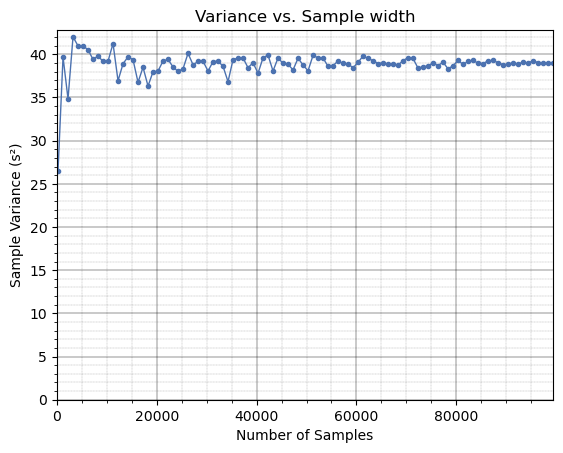

Variance is converging: Converge


'Converge'

In [29]:
# Plot variance with respect to the number of samples (to check if the variance converges to a value)


def check_variance_convergence(original_samples, show_plot=False):
    sample_sizes = range(200, len(original_samples) + 1, len(original_samples)//100)  # Increase sample size by 10 each step
    variances = []


    random.seed(42)
    #print(original_samples[:100])
    for size in sample_sizes:
        random_samples = random.sample(original_samples, size)
        #variance = np.var(random_samples, ddof=1)  # Calculate variance with Bessel's correction
        X_avg = sum(random_samples) / len(random_samples)
        S2 = sum([(x - X_avg) ** 2 for x in random_samples]) / (len(random_samples) - 1)
        variance = S2
        variances.append(variance)

    # Plot variance with respect to the number of samples
    # plot only dots
    if show_plot:
        fig, ax = plt.subplots()
        ax.plot(sample_sizes, variances, 'o-', markersize=3, color='#4c72b0', linewidth=1)
        ax.set_xlabel('Number of Samples')
        ax.set_ylabel('Sample Variance (s²)')
        ax.set_title('Variance vs. Sample width')
        ax.set_ylim(bottom=0)
        ax.set_xlim(left=0, right=sample_sizes[-1])
        ax.grid(True, which='major', linestyle='-', linewidth='0.3', color='black')
        ax.minorticks_on()
        ax.grid(True, which='minor', linestyle=':', linewidth='0.2', color='black')
        plt.show()
        # save plot as pdf
        fig.savefig('variance_vs_sample_width.pdf', format='pdf')

    # Check if variances vector seems converging
    def check_convergence_ratio(arr, window=50, tol=1e-1):
        arr = np.array(arr, dtype=np.float64)
        if len(arr) < window + 1:
            return "Inconcludente"

        # Calcola il rapporto tra termini successivi
        ratios = arr[1:] / (arr[:-1] + 1e-10)  # Evita divisioni per zero

        # Controlla la stabilità del rapporto negli ultimi "window" elementi
        recent_ratios = ratios[-window:]
        avg_ratio = np.mean(recent_ratios)
        
        #print(np.abs(recent_ratios - 1))

        if np.all(np.abs(recent_ratios - 1) < tol):
            return "Converge"
        elif avg_ratio > 1:
            return "Diverge"
        else:
            return "Decresce (possibile convergenza)"

    converging = check_convergence_ratio(variances)
    print("Variance is converging:", converging)
    return converging

# Choose increasing number of random samples from original samples
example_variance = repetitions_original['1']['true'][100]

check_variance_convergence(example_variance, show_plot=True)


In [49]:

import time

all_ok = True

# check for each repetition in repetitions_original
for distr in repetitions_original:
    for fairshare in repetitions_original[distr]:
        for N in repetitions_original[distr][fairshare]:
            print(f"Checking variance convergence for {distr} {fairshare} {N}")
            if check_variance_convergence(repetitions_original[distr][fairshare][N]) != "Converge":
                all_ok = False
            #time.sleep(1)

print("All ok:", all_ok)


Checking variance convergence for 0 true 58
Variance is converging: Converge
Checking variance convergence for 0 true 60
Variance is converging: Converge
Checking variance convergence for 0 true 61
Variance is converging: Converge
Checking variance convergence for 0 true 62
Variance is converging: Converge
Checking variance convergence for 0 true 63
Variance is converging: Converge
Checking variance convergence for 0 true 64
Variance is converging: Converge
Checking variance convergence for 0 true 65
Variance is converging: Converge
Checking variance convergence for 0 true 66
Variance is converging: Converge
Checking variance convergence for 0 true 67
Variance is converging: Converge
Checking variance convergence for 0 true 68
Variance is converging: Converge
Checking variance convergence for 0 true 69
Variance is converging: Converge
Checking variance convergence for 0 true 70
Variance is converging: Converge
Checking variance convergence for 0 true 71
Variance is converging: Converge

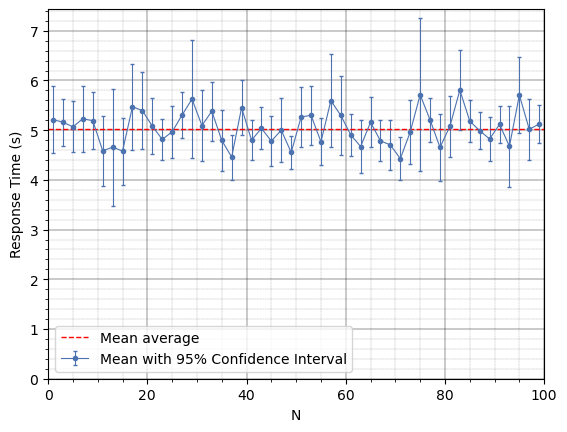

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
N & Average Range \\
\hline
1 & [4.537, 5.889] \\
\hline
20 & [4.539, 5.631] \\
\hline
40 & [4.419, 5.239] \\
\hline
60 & [4.448, 5.248] \\
\hline
80 & [4.512, 5.366] \\
\hline
100 & [4.351, 5.335] \\
\hline
\end{tabular}
\caption{Average range for selected N values}
\end{table}


In [20]:

repetitions = repetitions_sampled['1']['true']
#print(repetitions)
#repetitions = repetitions_original['1']['true']
#print(repetitions)

N = [i for i in range(1, len(repetitions_original['1']['true'])+1)] 
#N = [i for i in range(1, 251+1, 50)] # normalmente questo non c'è
average = []
confidence = []

alpha = 0.05
z = norm.ppf(1 - alpha/2)

for n in N:
    if len(repetitions[n]) <= 30:
        raise ValueError("Not enough samples")
    X = sum(repetitions[n]) / len(repetitions[n])
    S = (sum([(x - X) ** 2 for x in repetitions[n]]) / (len(repetitions[n]) - 1)) ** 0.5

    average.append(X)
    confidence.append(z * S / (len(repetitions[n]) ** 0.5))

#plt.errorbar(N, average, yerr=confidence, fmt='o', capsize=2, capthick=1, markersize=3)
plt.errorbar(N[::2], np.array(average)[::2], yerr=np.array(confidence)[::2], fmt='o', capsize=1.7, capthick=1
            , markersize=3, elinewidth=0.8, linestyle='-', linewidth=0.8, color='#4c72b0')
plt.axhline(y=np.mean(average), color='r', linestyle='--', linewidth=1, label='Mean of Averages')
plt.xlabel('N')
plt.ylabel("Response Time (s)")

#set y to staecolor=''rt at 0
plt.ylim(bottom=0)
plt.xlim(left=0, right=100)

plt.grid(True, which='major', linestyle='-', linewidth='0.3', color='black')
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', linewidth='0.2', color='black')
plt.legend(['Mean average', 'Mean with 95% Confidence Interval'])
plt.savefig('response_time_vs_N_exp_fairsharing.pdf', format='pdf')
plt.show()

# Print a copy-pastable LaTeX style table for values of N in [1, 20, 40, 60, 80, 100]
N_values = [1, 20, 40, 60, 80, 100]
table_data = []

for n in N_values:
    lower_bound = average[n-1] - confidence[n-1]
    upper_bound = average[n-1] + confidence[n-1]
    table_data.append((n, lower_bound, upper_bound))

# Print LaTeX table
print("\\begin{table}[h!]")
print("\\centering")
print("\\begin{tabular}{|c|c|}")
print("\\hline")
print("N & Average Range \\\\")
print("\\hline")
for row in table_data:
    print(f"{row[0]} & [{row[1]:.3f}, {row[2]:.3f}] \\\\")
    print("\\hline")
print("\\end{tabular}")
print("\\caption{Average range for selected N values}")
print("\\end{table}")

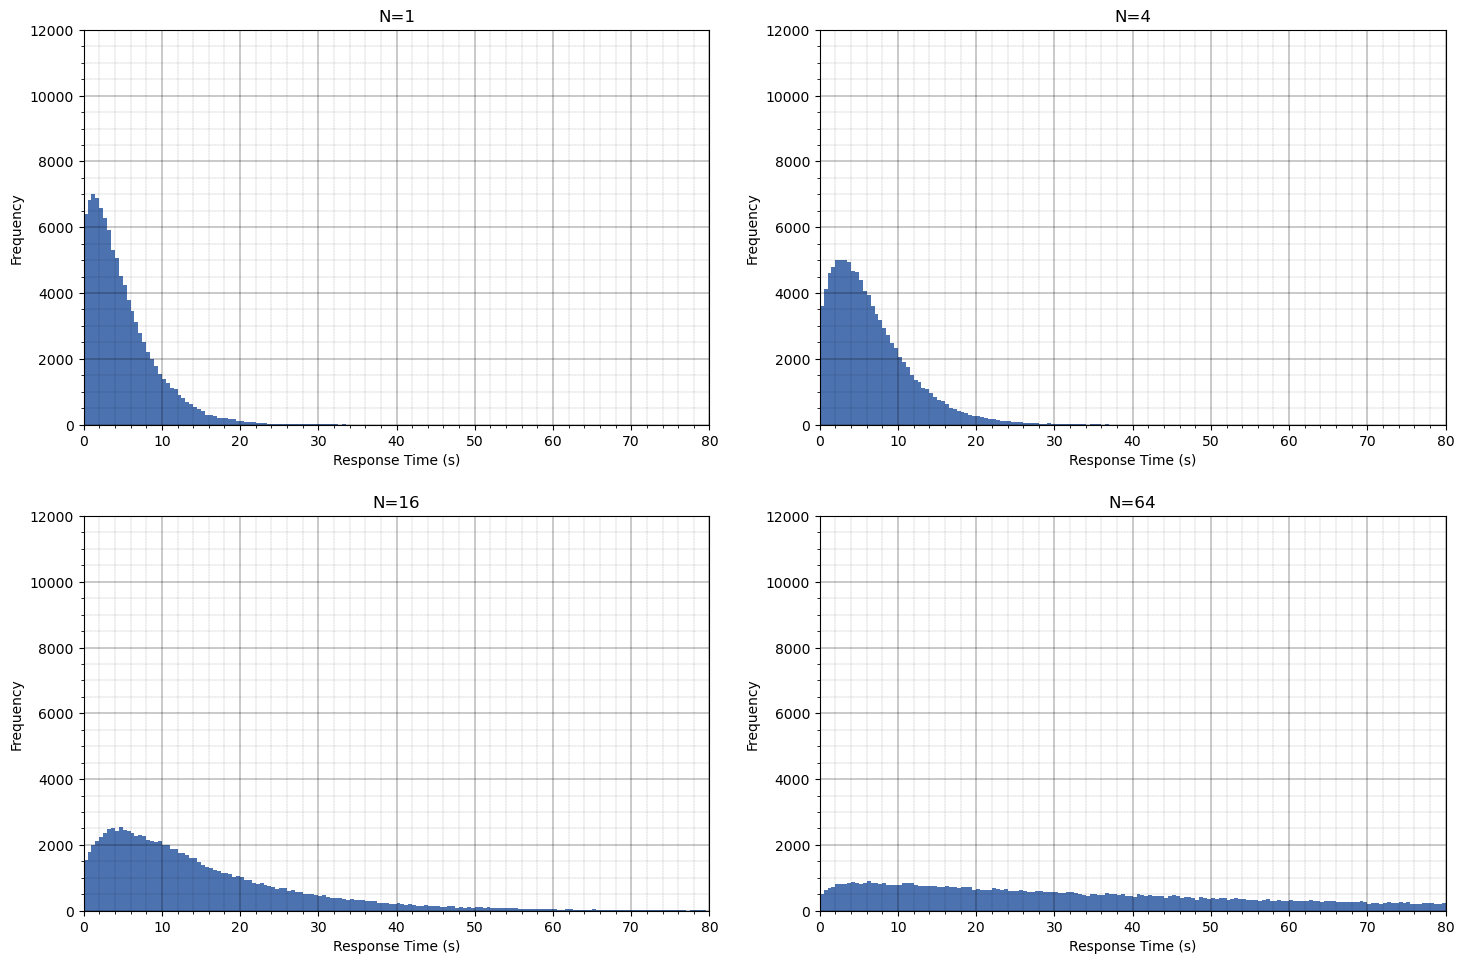

In [8]:
# Plot histogram for repetitions_sampled['1']['false'][10]
distr_plot = '1'
N_values = [1, 4, 16, 64]
experiment = repetitions_original[distr_plot]['false']
stat = 'taskTimeStat:vector'

if distr_plot == '1' and stat == 'taskTimeStat:vector':
    xlim = 80
    ylimit = 12000
    binsize = 0.5
    XLABEL = 'Response Time (s)'
elif distr_plot == '0' and stat == 'timeStat:vector':
    xlim = 55
    ylimit = 55000
    binsize = 0.5
    XLABEL = 'Response Time (s)'
else:
    print("NO")
    


#print(np.arange(0, max(experiment[10]) + binsize, binsize))

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
# No need to modify anything here as the x ticks are already shown in each plot
for i, n in enumerate(N_values):
    repetitions = experiment[n]
    axs[i].hist(repetitions, bins=np.arange(0, max(repetitions) + binsize, binsize), color='#4c72b0')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'N={n}')
    axs[i].grid(True, which='major', linestyle='-', linewidth='0.3', color='black')
    axs[i].minorticks_on()
    axs[i].grid(True, which='minor', linestyle=':', linewidth='0.2', color='black')
    axs[i].set_xlim(left=0, right=xlim)
    axs[i].set_ylim(top=ylimit, bottom=0)
    axs[i].set_xlabel(XLABEL)

plt.tight_layout(pad=2.0)

plt.savefig('response_time_histograms_exp_segregation.pdf', format='pdf')
#plt.savefig('response_time_histograms_exp_fairshare.pdf', format='pdf')
#plt.savefig('interdeparturetime_histograms_exp_fairshare.pdf', format='pdf')
plt.show()


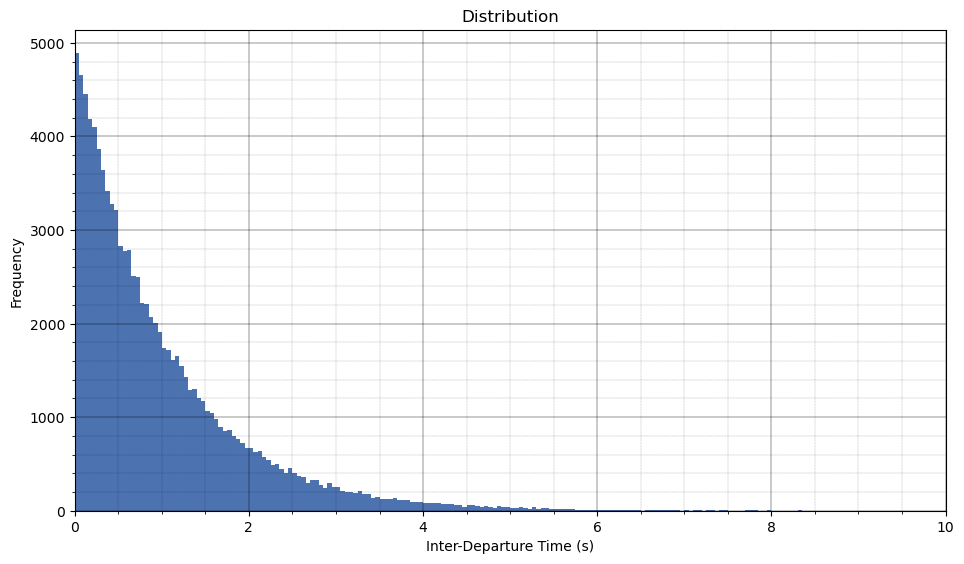

In [204]:
# use that for interdeparture time
# Plot histogram for repetitions_sampled['1']['false'][100]
n = 100
repetitions = repetitions_original['1']['true'][n]

xlim = 10
ylimit = 100
binsize = .05
XLABEL = 'Inter-Departure Time (s)'

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(repetitions, bins=np.arange(0, max(repetitions) + binsize, binsize), color='#4c72b0')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution')
ax.grid(True, which='major', linestyle='-', linewidth='0.3', color='black')
ax.minorticks_on()
ax.grid(True, which='minor', linestyle=':', linewidth='0.2', color='black')
ax.set_xlim(left=0, right=xlim)
#ax.set_ylim(top=ylimit, bottom=0)
ax.set_xlabel(XLABEL)

plt.tight_layout(pad=2.0)
plt.savefig('interdeparturetime_histogram_N100_exp_fairsharing.pdf', format='pdf')
plt.show()

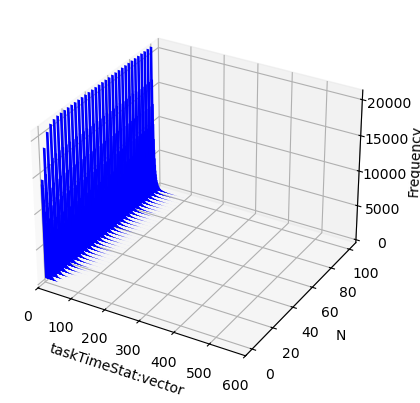

In [111]:
from mpl_toolkits.mplot3d import Axes3D

# plot distribution of the original samples

repetitions = repetitions_original['1']['true']

# make a 3D histogram for various N
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Prepare data for 3D histogram
for n in range(1, len(repetitions)+1, 3):
    hist, bins = np.histogram(repetitions[n], bins=np.arange(0, 601, 1))
    bins = 0.5 * (bins[:-1] + bins[1:])  # Convert bin edges to centers
    ax.bar(bins, hist, zs=n, zdir='y', alpha=1, label=f'N={n}', width=8, color='b')
    # set x limits
    ax.set_xlim(0, 600)
    
ax.set_xlabel(stat)
ax.set_ylabel('N')
ax.set_zlabel('Frequency')
#plt.legend(loc='upper right')
plt.show()



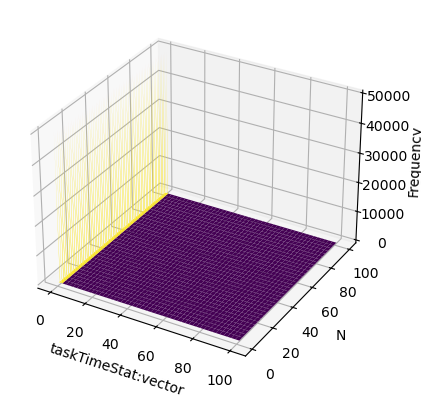

In [192]:

repetitions = repetitions_original['0']['true']

# Prepare data for surface plot
X, Y = np.meshgrid(np.arange(0, 101, 0.1), np.arange(1, len(repetitions)+1, 3))
Z = np.zeros_like(X, dtype=float)

for idx, n in enumerate(range(1, len(repetitions)+1, 3)):
    hist, bins = np.histogram(repetitions[n], bins=np.arange(0, 101.1, 0.1))
    Z[idx, :] = hist

# Plot surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel(stat)
ax.set_ylabel('N')
ax.set_zlabel('Frequency')
plt.show()


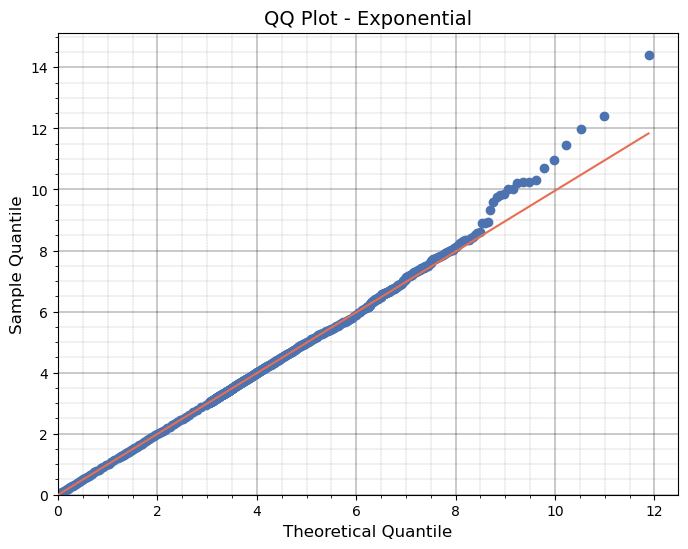

In [299]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unisci tutti i dati in una singola lista
all_data = repetitions_original['1']['true'][100]
#all_data = []
#for key in data:
#    all_data.extend(data[key])


# Converti i dati in un array di NumPy
all_data = np.array(all_data)

# Lista delle distribuzioni da testare
distributions = ['expon']

# Crea un QQ plot per ciascuna distribuzione
for distribution in distributions:
    plt.figure(figsize=(8, 6))
    stats.probplot(all_data, dist=distribution, plot=plt)
    # Plot less points at the start and more at the end
    plt.title(f"QQ Plot - Exponential", fontsize=14)
    # Plot less points at the start and more at the end using exponential proportion
    line = plt.gca().get_lines()[0]
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    n = len(x_data)
    #indices = np.concatenate([np.unique(np.logspace(0, np.log10(n-1), num=500, dtype=int)), np.arange(int(n/1.3), n, 1)])
    indices = np.concatenate([np.arange(0, int(n/1.4), 2000), np.arange(int(n/1.4), int(n/1.05), 500), np.arange(int(n/1.05), int(n/1.002), 10), np.arange(int(n/1.002), n, 1)])
    plt.plot(x_data[indices], y_data[indices], 'o', color='#4c72b0', markersize=6)
    line.remove()
    plt.xlabel('Theoretical Quantile', fontsize=12)
    plt.ylabel('Sample Quantile', fontsize=12)
    plt.grid(True)
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.xlim(0)
    plt.ylim(0)
    #plt.gca().get_lines()[0].set_color('#4c72b0')  # Set the color of the QQ plot line
    plt.gca().get_lines()[0].set_color('#e76f51')  # Set the color of the QQ plot line to a nice red-ish color
    plt.gca().get_lines()[0].set_zorder(10)  # Bring the line to the top of the plot
    #plt.gca().get_lines()[0].set_color('#e69f00')  # Set the color of the QQ plot line
    #plt.gca().get_lines()[1].set_color('#0072b2')  # Set the color of the QQ plot line
    #plt.gca().get_lines()[1].set_color('#009e73')  # Set the color of the QQ plot line
    #plt.gca().get_lines()[0].set_color('#d55e00')  # Set the color of the QQ plot line
    plt.savefig('interdeparture_qq_plot_exp_fairsharing_N100.pdf', format='pdf')
    plt.show()

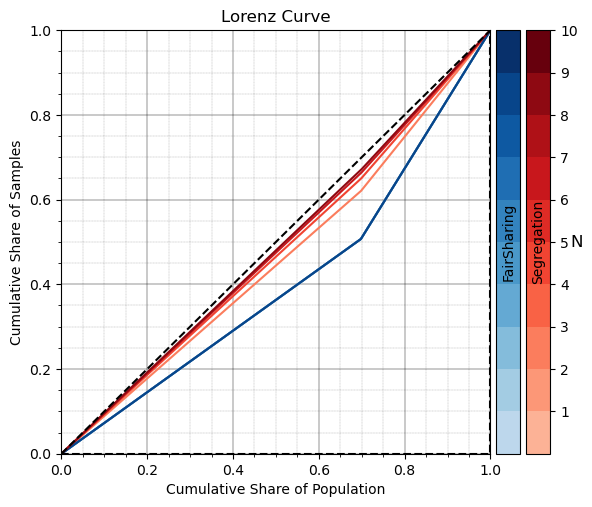

In [178]:
distr_plot = '0'

# Add colorbars for the legend
MAX_N = 10
STEP = MAX_N // 5

COLOR_OFFSET = 0.2

fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(5.5)
fig.subplots_adjust(right=0.84)
for n in range(1, MAX_N+1, STEP):
    samples_true = repetitions_original[distr_plot]['true'][n]
    samples_false = repetitions_original[distr_plot]['false'][n]
    samples_sorted_true = np.sort(samples_true)
    samples_sorted_false = np.sort(samples_false)
    cumulative_sum_true = np.cumsum(samples_sorted_true)
    cumulative_sum_false = np.cumsum(samples_sorted_false)
    cumulative_sum_normalized_true = cumulative_sum_true / cumulative_sum_true[-1]
    cumulative_sum_normalized_false = cumulative_sum_false / cumulative_sum_false[-1]
    population_share_true = np.arange(1, len(samples_true) + 1) / len(samples_true)
    population_share_false = np.arange(1, len(samples_false) + 1) / len(samples_false)
    ax.plot(population_share_true, cumulative_sum_normalized_true, label=f'Lorenz Curve True N={n}', color=plt.cm.Blues((n/MAX_N)*(1-COLOR_OFFSET) + COLOR_OFFSET))
    ax.plot(population_share_false, cumulative_sum_normalized_false, label=f'Lorenz Curve False N={n}', color=plt.cm.Reds((n/MAX_N)*(1-COLOR_OFFSET) + COLOR_OFFSET))

ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Line of Equality')
ax.plot([0, 1, 1], [0, 0, 1], linestyle='--', color='black', label='Line of Maximum Unfairness')
ax.set_xlabel('Cumulative Share of Population')
ax.set_ylabel('Cumulative Share of Samples')
ax.set_title('Lorenz Curve')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.3', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

# Create new axes for colorbars
cax_true = fig.add_axes([0.85, 0.11, 0.04, 0.77])
cax_false = fig.add_axes([0.90, 0.11, 0.04, 0.77])

import matplotlib.colors as mcolors

# Define a custom colormap
def custom_cmap(base_cmap, offset=COLOR_OFFSET, max_n=MAX_N):
    colors = [base_cmap((n/max_n)*(1-offset) + offset) for n in range(1, max_n+1)]
    return mcolors.ListedColormap(colors)

# Create custom colormaps for true and false samples
cmap_true = custom_cmap(plt.cm.Blues)
cmap_false = custom_cmap(plt.cm.Reds)

# Use the custom colormaps
sm_true = plt.cm.ScalarMappable(cmap=cmap_true, norm=plt.Normalize(vmin=0, vmax=MAX_N))
sm_true.set_array([])
cbar_true = plt.colorbar(sm_true, cax=cax_true, ticks=[])
cbar_true.set_label('FairSharing', labelpad=-13.5)

sm_false = plt.cm.ScalarMappable(cmap=cmap_false, norm=plt.Normalize(vmin=0, vmax=MAX_N))
sm_false.set_array([])
cbar_false = plt.colorbar(sm_false, cax=cax_false, ticks=np.linspace(1, MAX_N, 10))
cbar_false.set_label('Segregation', labelpad=-33.5)
#cbar_false.set_label('N', labelpad=0)

# add text to the plot
ax.text(1.2, 0.5, 'N', fontsize=12, color='black', ha='center', va='center')

plt.savefig('lorenz_curve_const_p_0.3.pdf', format='pdf')
plt.show()